# Лабораторная работа №4б
## Вариант №11
Есть 2 бесконечные плоскости с параллельными прорезями (плоскости параллельны друг другу). Прорези проделаны с определенным периодом. От стенки к стенке течет жидкость. Построить векторное поле скорости.

Начнем с того, что в силу бесконечности поскостей и периодичности прорезей, задача эффективно двумерная, причем в прямоугольнике (достаточно захватить один период стенки и прорези).

Введем потенциал скорости $u$:

$$ v = -\text{grad} u  $$

Жидкость будем предполагать несжимаемой, в таком случае уравнение неразрывности примет простой вид, выпишем постановку:

\begin{equation*}
\begin{cases}
    \Delta u = 0, \ \ 0 < x < H,\ \ 0 < y < l + p \\
    \displaystyle u_x(0, y) = \eta{(l - y)}v_0,\ \ u_x(H, y) = \eta{(l + d -y)} \eta{(y - d)} v_0   \\
    u(x, y + l + p) = u(x, y) 
\end{cases}
\end{equation*}

Здесь $H$ — расстояние между плоскостями, $l$ — ширина щели, а $p$ — расстояние между щелями, $d$ — сдвиг щели на правой плоскости.

Оператор удачно подтянем из первой части лабораторной работы:

$ \displaystyle (Lu)_{i,j} = [i > 1] \frac{u_{i,j} - u_{i-1, j}}{h_x^2} + [i < n_x] \frac{u_{i,j} - u_{i+1,j}}{h_x^2} + [j > 1] \frac{u_{i,j} - u_{i, j-1}}{h_y^2} + [j < n_y] \frac{u_{i,j} - u_{i, j+1}}{h_y^2} +$

$\displaystyle \ \ \ \ \ \ \ \ \ \ \ \ \ \ + [j = 1]\frac{u_{i, j} - u_{i, n_y}}{h_y^2} + [j = n_y]\frac{u_{i,j} - u_{i, 1}}{h_y^2}$

$\displaystyle (F)_{i,j} = [i = 1]\frac{\varphi_{Lj}}{h_x} + [i = x_n]\frac{\varphi_{Rj}}{h_x}$

In [105]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import sparse as sp
from scipy.sparse import linalg as LA
%matplotlib inline

In [106]:
H = 10
l = 3
p = 7
d = 4
v_0 = 10
# таким образом будем решать задачу в квадрате 10 на 10

In [107]:
def getL_csr(n_x, n_y, h_x, h_y):
    # двумерный массив элементы которого равны  индексу ячейки
    k = np.arange(n_x * n_y, dtype=int).reshape((n_x, n_y)) 

    I, J = np.meshgrid(np.arange(n_x), np.arange(n_y))
    I, J = I.flatten(), J.flatten()

    iC = k[I, J].flatten() # есть соседи снизу и сверху
    iB = k[I, (J - 1) % n_y].flatten() # соседи снизу
    iT = k[I, (J + 1) % n_y].flatten() # соседи сверху

    iHR = k[:-1, :].flatten() # есть сосед справа
    iR  = k[1: , :].flatten() # сосед справа

    iHL = k[1:  , :].flatten() # есть сосед слева
    iL  = k[:-1 , :].flatten() # сосед слева

    R1, C1, V1 = iC, iC, np.full(iC.size, +2.0/h_y**2)
    R2, C2, V2 = iC, iB, np.full(iC.size, -1.0/h_y**2)
    R3, C3, V3 = iC, iT, np.full(iC.size, -1.0/h_y**2)

    R4, C4, V4 = iHL, iHL, np.full(iHR.size, +1.0/h_x**2)
    R5, C5, V5 = iHL, iL,  np.full(iHL.size, -1.0/h_x**2)

    R6, C6, V6 = iHR, iHR, np.full(iHR.size, +1.0/h_x**2)
    R7, C7, V7 = iHR, iR,  np.full(iHR.size, -1.0/h_x**2)

    row = np.concatenate((R1, R2, R3, R4, R5, R6, R7))
    col = np.concatenate((C1, C2, C3, C4, C5, C6, C7))
    val = np.concatenate((V1, V2, V3, V4, V5, V6, V7))

    return sp.csr_matrix((val, (row, col)))

def phi_L(y):
    return -np.heaviside(l - y, 0) * v_0

def phi_R(y):
    return np.heaviside(l + d - y, 0) * v_0 * np.heaviside(y - d, 0)

def RHS(X, Y, h_x, h_y):
    res = np.zeros_like(X)
    res[0, :] += phi_L(Y[0, :]) / h_x
    res[-1,:] += phi_R(Y[-1,:]) / h_x
    return res - res.mean()

In [108]:
h_0 = 0.5
l_x, l_y = H, p + l
n_x, n_y = int(np.round(l_x / h_0)), int(np.round(l_y / h_0))
h_x, h_y = l_x / n_x, l_y / n_y
x = np.linspace(h_x / 2, l_x - h_x / 2, n_x)
y = np.linspace(h_y / 2, l_y - h_y / 2, n_y)
X, Y = np.meshgrid(x, y, indexing='ij')

L = getL_csr(n_x, n_y, h_x, h_y)
F = RHS(X, Y, h_x, h_y).flatten()

In [109]:
u_sp = LA.spsolve(L, F).reshape((n_x, n_y))
u_sp -= u_sp.mean()

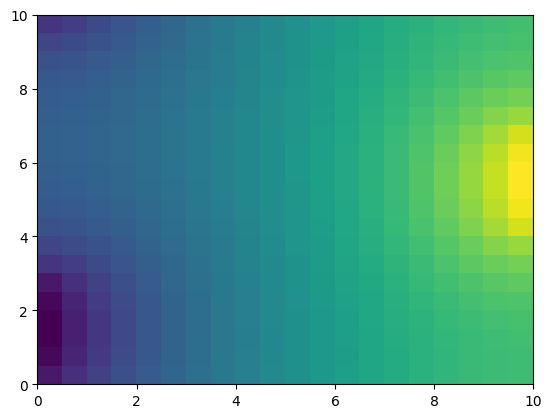

In [110]:
plt.imshow(u_sp.T, origin='lower', extent=(0, l_x, 0, l_y), aspect='auto')
plt.show()

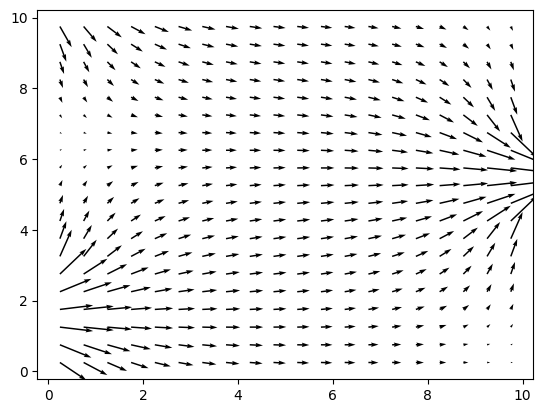

In [111]:
vy, vx = np.gradient(u_sp.T)
plt.quiver(X.T, Y.T, vx, vy)